<a href="https://colab.research.google.com/github/YogithL/Data-Science/blob/main/Yogi_LogaU5proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm
from scipy.interpolate import PchipInterpolator

# **Can We Predict Shot Range from the Horizontal Spread of Shotgun Pellets?**
Determining the shot range is crucial for crime scene reconstruction in forensics. By analyzing the spread of shotgun pellets from a central axis, scientists can potentially predict the distance a gun was shot from. In this project, I aim to explore whether the relationship between horizontal spread and shot range is linear.

## **The Data**
The data below was extracted from the Forensic Science International journal, Vol. 28.

In [2]:
gun_data = pd.read_csv('https://raw.githubusercontent.com/YogithL/Data-Science/refs/heads/main/Unit5%20Take%204', dtype={'pellDiam':'category'})
gun_data

,pellDiam,shotRng,shotID,vertDist,horzDist
0,2,0.7,1,20,16
1,2,0.7,2,20,20
2,2,0.7,3,21,20
3,2,0.7,4,20,19
4,2,0.7,5,20,20
...,...,...,...,...,...
215,8,25.0,1,400,460
216,8,25.0,2,425,400
217,8,25.0,3,450,342
218,8,25.0,4,490,500


Since we're concerned about horzDist and shotRng, let's remove the variables that we definitely won't need in the future. At this point, it's also important to note that horzDist was measured in mm while shotRng was measured in m.

In [17]:

gun_data=gun_data.loc[:, ['pellDiam', 'shotRng', 'horzDist']] #Removing all columns excluding pellDiam, shotRng, and horzDist

gun_data

,pellDiam,shotRng,horzDist
0,2,0.7,16
1,2,0.7,20
2,2,0.7,20
3,2,0.7,19
4,2,0.7,20
...,...,...,...
215,8,25.0,460
216,8,25.0,400
217,8,25.0,342
218,8,25.0,500


## **Visualizations**


Now that we have our data all cleaned up, let's visualize it. I'll use the KDE & Rug plot to get an idea of the probability distribution for our likelihood. And to display the relationship between both our variables, I'll use a scatter plot.

<Axes: xlabel='horzDist', ylabel='Density'>

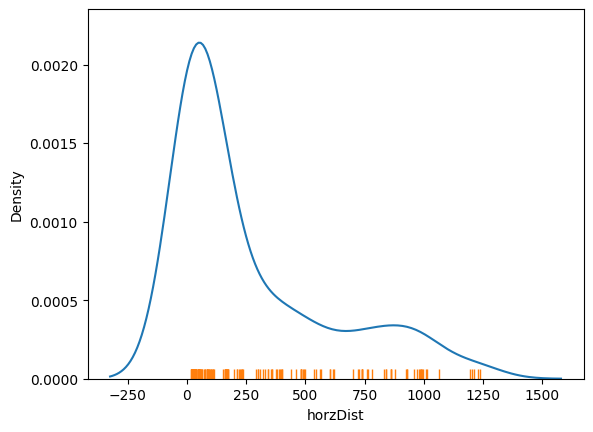

In [4]:
sns.kdeplot(data=gun_data, x="horzDist")
sns.rugplot(data=gun_data, x="horzDist")

<Axes: xlabel='horzDist', ylabel='shotRng'>

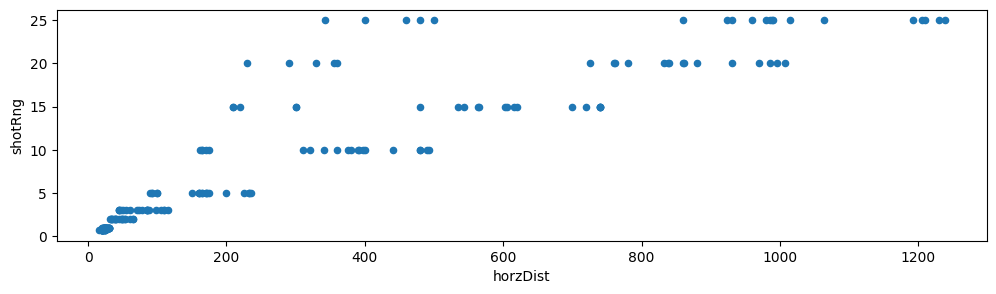

In [5]:
gun_data.plot(x="horzDist", y="shotRng", figsize=(12, 3), kind="scatter")

Alright, from the KDE + Rug plot, it's clear that our data has a positive skew. While there is a slight hump near the RHS, the probability distribution isn't too unusual. Our scatter plot, however, is abnormal. We have **2 strongly correlated positive** lines projecting outward from the origin. For now, let's set this aside and continue; we'll revist it in the future.  

## **Choosing Likelihoods and Priors**


Given the constraints above, I instantly knew what likelihood I wanted to use. Since the data from my last project had a similar shape, I decided that using a **Gamma distribution** would work great. Specifically, the distribution was built to handle cases like this where a large proportion of the data is concentrated with comparably less outliers.    

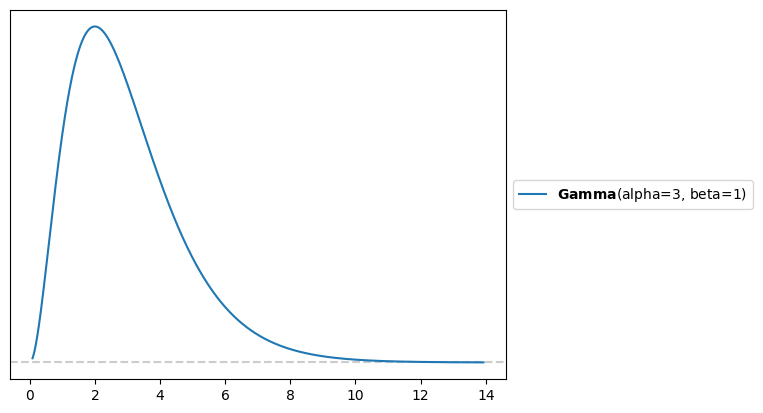

Since I know virtually zero information about how shotgun pellets are dispersed, I'm opting to use lightly informative priors. So, wherever priors are needed, I'm going to use the **HalfNormal distribtion** simply because it's non-negative.

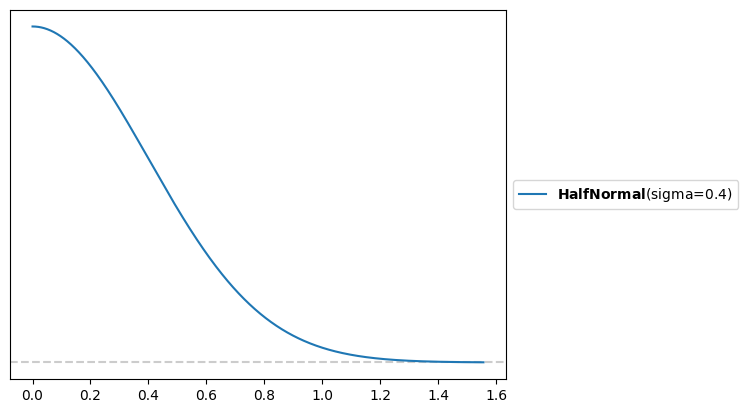

## **Constructing our Linear Model**

In [6]:
with pm.Model() as gun_det_model:

    #priors for line for our mean
    α = pm.HalfNormal("α", sigma=10)
    β = pm.HalfNormal("β", sigma=10)

    #priors for the line for our standard deviation
    γ = pm.HalfNormal("γ", sigma=10)
    δ = pm.HalfNormal("δ", sigma=10)

    #mean line
    μ = pm.Deterministic("μ", α + β * gun_data.horzDist)

    #standard deviation line; this allows our variance to vary over th x values
    σ = pm.Deterministic("σ", γ + δ * gun_data.horzDist)

    #normal likelihood
    y_pred = pm.Gamma("y_pred", mu=μ, sigma=σ, observed=gun_data.shotRng)

    idata_det = pm.sample()

Output()

Output()

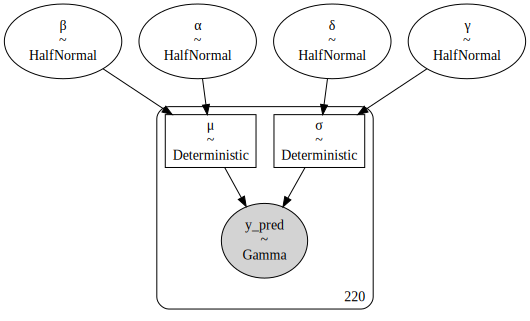

In [7]:
pm.model_to_graphviz(gun_det_model)

The graph above is a visualization of our model. Since we're using a Gamma distribution, we have two parameters, mu and sigma, represented by the deterministics μ & σ. Each of these deterministic is then associated with its own prior distributions: $\alpha$, $\beta$, $\delta$, and $\gamma$.


Text(0, 0.5, 'shotRng')

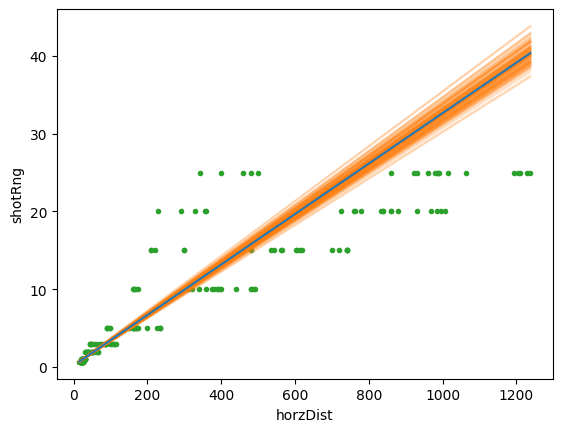

In [8]:
#grabs 100 posterior samples
posterior = az.extract(idata_det, num_samples=100)

# grabbing x values for graphing.
x_plot = xr.DataArray(
    np.linspace(gun_data.horzDist.min(), gun_data.horzDist.max(), 50),
    dims="plot_id"
    )

# this creates the expected line
mean_line = posterior["α"].mean() + posterior["β"].mean() * x_plot

#These are a 50 lines that our model came up with
lines = posterior["α"] + posterior["β"] * x_plot

#set up plot
_, ax = plt.subplots()

#plots 50 other lines our model came up with.
ax.plot(x_plot, lines.T, c="C1", alpha=0.2, label="lines")

#plots the mean line
ax.plot(x_plot, mean_line, c="C0", label="mean line")

#plot the raw data
ax.plot(gun_data.horzDist, gun_data.shotRng, "C2.", zorder=-3)

#label axes and create legend
ax.set_xlabel("horzDist")
ax.set_ylabel("shotRng")

From the posterior visualization above, it appears the linear model is a terrible fit. Although the data itself is linear, it diverges into two distinct lines shortly past the origin. As a result, our model tries to fit both lines but ultimately fails since it can't capture the underlying issue properly. Before drawing further conclusions, let's run a posterior check and posterior predictive distribution.

Output()

Text(0, 0.5, 'shotRng')

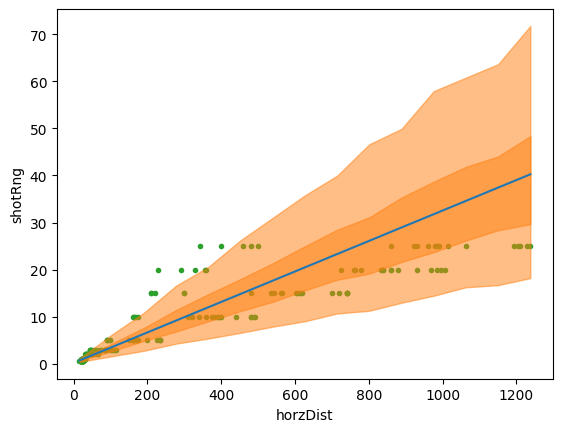

In [9]:
# posterior predictive check
pm.sample_posterior_predictive(idata_det, model=gun_det_model,  extend_inferencedata=True)

#plots the posterior predictive distribution

#grabs the expected line, or line of best fit formula
mean_line = idata_det.posterior["μ"].mean(("chain", "draw"))

#creates some x values to run through our line formula
horzDist = np.random.normal(gun_data.horzDist.values, 0.01)
idx = np.argsort(horzDist)
x = np.linspace(horzDist.min(), horzDist.max(), 15)

#grabs the 94% HDI and 50% HDI, and sets them up for graphing.
y_pred_q = idata_det.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(horzDist[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

#plots raw data and our line of best fit
_, ax = plt.subplots()
ax.plot(gun_data.horzDist, gun_data.shotRng, "C2.", zorder=-3)
ax.plot(gun_data.horzDist[idx], mean_line[idx], c="C0")


#graphs the 94% and 50% HDIs
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

#labels
ax.set_xlabel("horzDist")
ax.set_ylabel("shotRng")

Output()

<Axes: xlabel='y_pred'>

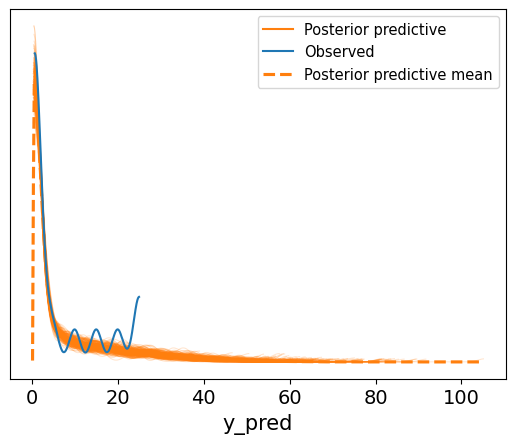

In [10]:
pm.sample_posterior_predictive(
    idata_det, model = gun_det_model, extend_inferencedata=True
    )

az.plot_ppc(idata_det, num_pp_samples=200, colors=["C1", "C0", "C1"])


Well, all three of our tests seem to indicate that this linear model is trash. The reason, however, likely stems from the variation of our pellDiam variable. Since our data consists of 4 different-sized shotgun pellets, each one will exhibit different firing patterns. To account for this, we should create a hierarchical linear model since it can capture variability at multiple levels. Also, I doubt any adjustments to our current model will improve its performance so it's best to move on.

## **Constructing our Hierarchical Linear Model**

In [11]:
#this is an array of the different pellet diameters,
#except they are given an int (number) label instead of a string (of letters)
pell_idx = gun_data.pellDiam.cat.codes.values

#an array of the strings that represent position
pell_codes = gun_data.pellDiam.cat.categories

#puts coords in a dict, so pymc can read them
gun_coords = {"pellDiam": pell_codes}


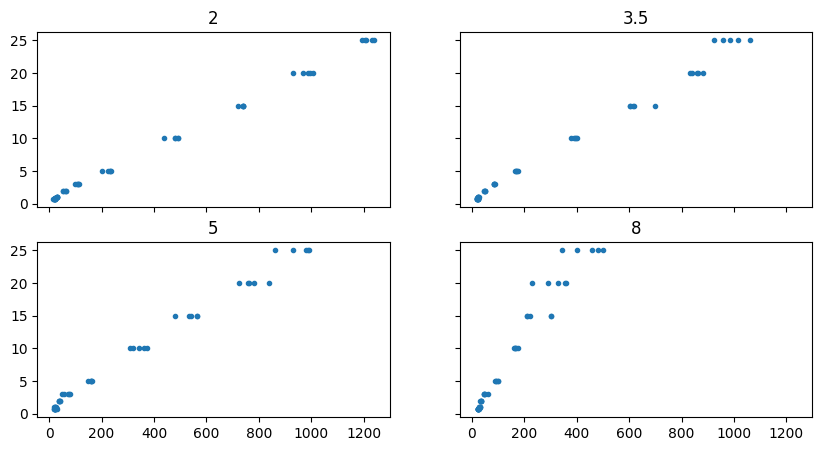

In [12]:
_, ax = plt.subplots(2, 2, figsize=(10, 5), sharex=True, sharey=True)
ax = np.ravel(ax)

#make a scatter plot for each pellDiam
for i, p in enumerate(pell_codes):
    ax[i].scatter(
        x = gun_data.query('pellDiam == @p')['horzDist'],
        y =  gun_data.query('pellDiam == @p')['shotRng'],
        marker=".")
    ax[i].set_title(f"{p}")


In [13]:
#h for hierarchical
with pm.Model(coords=gun_coords) as h_model:
    # hyper-priors
    α_μ = pm.Normal("α_μ", mu=gun_data['shotRng'].mean(), sigma=3)
    α_σ = pm.HalfNormal("α_σ", 5)
    β_μ = pm.Normal("β_μ", mu=0, sigma=3)
    β_σ = pm.HalfNormal("β_σ", sigma=5)

    # priors
    α = pm.Normal("α", mu=α_μ, sigma=α_σ, dims="pellDiam")
    β = pm.Normal("β", mu=β_μ, sigma=β_σ, dims="pellDiam")
    σ = pm.HalfNormal("σ", 5)

    #likelihood
    #the linear part of the model is put directly into mu
    y = pm.Normal("y_pred",
                  mu=α[pell_idx] + β[pell_idx] * gun_data['horzDist'],
                  sigma=σ,
                  observed=gun_data['shotRng'])

    idata_h = pm.sample(target_accept=0.99)

Output()

Output()

ERROR:pymc.stats.convergence:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

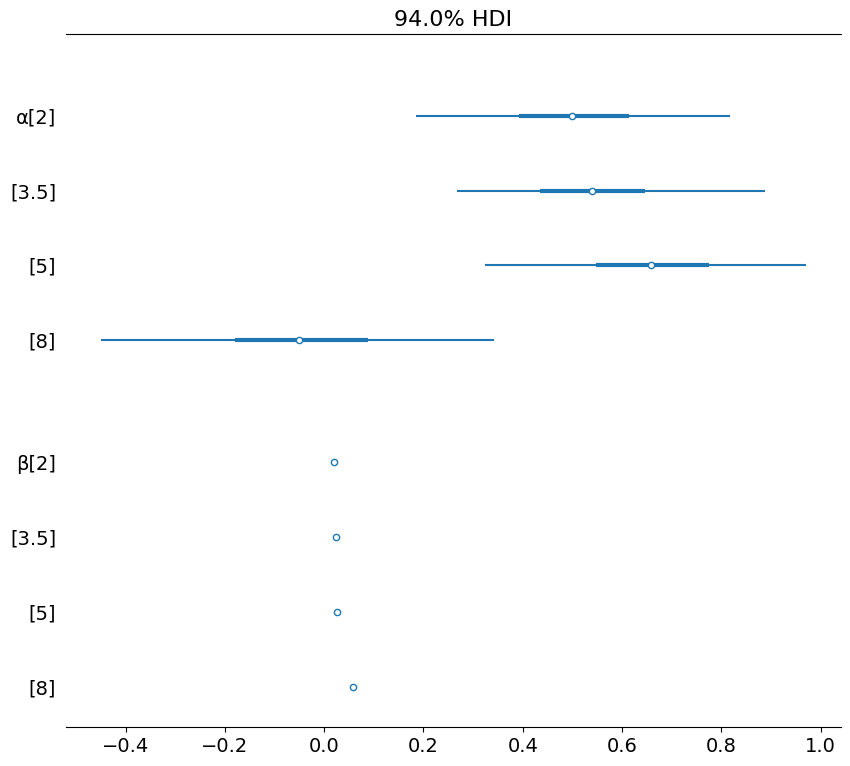

In [14]:
az.plot_forest(idata_h, var_names=["α", "β"], combined=True, figsize=(10, 9))

Above are the slopes and y-intercepts our model produced for each pellet diameter, and below, we're plotting them as lines with the posterior.

/usr/local/lib/python3.10/dist-packages/arviz/plots/hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.10/dist-packages/arviz/plots/hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.10/dist-packages/arviz/plots/hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.10/dist-packages/arviz/plots/

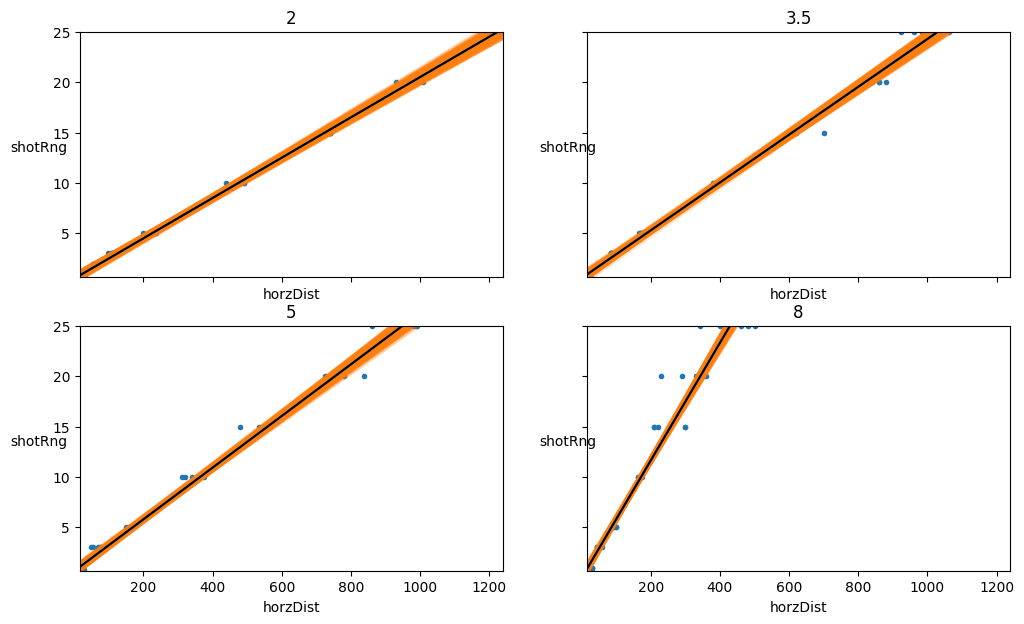

In [15]:
_, ax = plt.subplots(2, 2, figsize=(12, 7), sharex=True, sharey=True)
ax = np.ravel(ax)

#x values for putting through our linear equation, in order to graph the line
x_range = xr.DataArray(
    np.linspace(gun_data.horzDist.min(), gun_data.horzDist.max(), 50),
    dims="plot_id"
    )

#grab the posterior
posterior = az.extract(idata_h)

#plot all 4 lines against the data
for i, p in enumerate(pell_codes):
    #plot raw data
    ax[i].scatter(
        x = gun_data.query('pellDiam == @p')['horzDist'],
        y = gun_data.query('pellDiam == @p')['shotRng'],
        marker=".")
    #titles and labels
    ax[i].set_title(f"{p}")
    ax[i].set_xlabel("horzDist")
    ax[i].set_ylabel("shotRng", labelpad=10, rotation=0)

    #grab posterior info
    alphas = posterior["α"].sel(pellDiam=p)
    betas = posterior["β"].sel(pellDiam=p)
    alpha_m = alphas.mean("sample").item()
    beta_m = betas.mean("sample").item()

    lines = alphas + betas * x_plot
    ax[i].plot(x_plot, lines.T, c="C1", alpha=0.2, label="lines")

    mean_line = alphas.mean() + betas.mean() * x_plot
    ax[i].plot(x_plot, mean_line, c="C0", label="mean line")


    #plot the posterior
    ax[i].plot(x_range, alpha_m + beta_m * x_range, c="k")

    az.plot_hdi(x_range, alphas + betas * xr.DataArray(x_range).transpose(), ax=ax[i])

    #set window size
    plt.xlim(gun_data['horzDist'].min() - 0.01, gun_data['horzDist'].max() + 0.01)
    plt.ylim(gun_data['shotRng'].min() - 0.01, gun_data['shotRng'].max() + 0.01)

So this looks promising, but before jumping to conclusions, lets take a look at the posterior check.

/usr/local/lib/python3.10/dist-packages/arviz/plots/hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.10/dist-packages/arviz/plots/hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.10/dist-packages/arviz/plots/hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.10/dist-packages/arviz/plots/

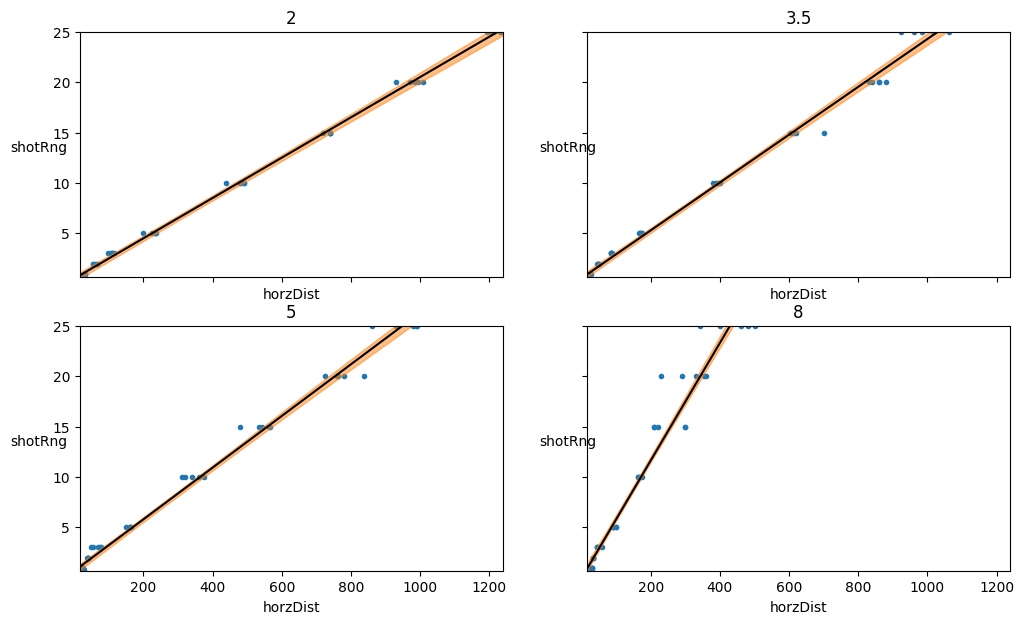

In [16]:
_, ax = plt.subplots(2, 2, figsize=(12, 7), sharex=True, sharey=True)
ax = np.ravel(ax)
#x values for putting through our linear equation, in order to graph the line
x_range = np.linspace(gun_data['horzDist'].min(), gun_data['horzDist'].max(), 10)
#grab the posterior
posterior = az.extract(idata_h)

#plot all 12 lines against the data
for i, p in enumerate(pell_codes):
    #plot raw data
    ax[i].scatter(
        x = gun_data.query('pellDiam == @p')['horzDist'],
        y = gun_data.query('pellDiam == @p')['shotRng'],
        marker=".")
    #titles and labels
    ax[i].set_title(f"{p}")
    ax[i].set_xlabel("horzDist")
    ax[i].set_ylabel("shotRng", labelpad=10, rotation=0)
    #grab posterior info
    alphas = posterior["α"].sel(pellDiam=p)
    betas = posterior["β"].sel(pellDiam=p)
    alpha_m = alphas.mean("sample").item()
    beta_m = betas.mean("sample").item()
    #plot the posterior
    ax[i].plot(x_range, alpha_m + beta_m * x_range, c="k")
    az.plot_hdi(x_range, alphas + betas * xr.DataArray(x_range).transpose(), ax=ax[i])
    #set window size
    plt.xlim(gun_data['horzDist'].min() - 0.01, gun_data['horzDist'].max() + 0.01)
    plt.ylim(gun_data['shotRng'].min() - 0.01, gun_data['shotRng'].max() + 0.01)

Since any line drawn in the orange 94% HDI has a 94% chance of being the true line of best fit, I'd say this model did a great job! Just as we saw in the initial scatterplot, it appears all our lines are strongly correlated and positive.  

## **Final Thoughts**

So we initially tried a Linear model, but because of the variations in pellet diameter, that didn't work out. Then, after switching to a Hierarchical model, we took into account the distinct patterns and variability in each pellet's performance. This approach was successful, and we were able to create four lines that were both extremely accurate and precise. Ultimately, the results of this project strongly support a linear dependence between the horizontal spread of shotgun pellets and the distance from where the gun was fired.

In the future, I'd like to revist this data because I think I could improve this model further. If we learn to incorporate multiple variables, I'm sure I could also use vertical spread to better predict the shot range.

While I'm happy with the outcomes, having acess to more data could've further improved the accuracy of the model. With a larger dataset, the model could've captured subtle variations while also removing the weight outliers had on the best-fit line.

